<a href="https://colab.research.google.com/github/stmoon/CS470/blob/master/CS470_Assignment_1_CNN_classification_with_Cifar10_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS470 Assignment #1: CNN classification with Cifar10
====

Primary TA : Myeongjae Jang

TA's E-mail : myeongjae0409@kaist.ac.kr

## Instruction

- Modify the baseline CNN model to improve the classification performance on Cifar10 dataset. In addition to the model definition, you can modify any parts of this colab example to improve the test accuracy (e.g., learning rate, batch size, etc.)
- Train your CNN model and compare it to the baseline (in terms of training loss and the test accuracy).
- Explain your modifications and discuss how you improved the test accuracy.

## Submission guidelines

- Your code and report will be all in Colab. Copy this example to your google drive and edit it to complete your assignment. Add sections at the bottom of this example to discuss the results. For discussion and analysis, we highly encourage you to use graphics if possible (e.g., plots, images, etc.). 
- To make grading efficient, please highlight all contributions & modifications you made clearly. We highly encourage you to add code blocks in the discussion section to discuss your modifications (e.g., you can describe the model definition in the discussion section using the code blocks).
- We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error and loads your pre-trained model properly. Submissions failed to run or reproduce the results will get a substantial penalty. 
- In this assignment, **we are not allowing fine-tuning from the pre-trained model** (e.g. ImageNet pre-trained models). You should train your  model on Cifar10 dataset from scratch. 

## Deliverables
- Download your Colab notebook and the pre-trained model, and submit a zip file in a format: [StudentID].zip. Please double-check that you locate and load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions. 

## Grading policy

- **Code** (50%): Your code should work and outperform the baseline model in terms of the test accuracy. 
- **Report** (50%): Explain your modification and justify how it improved the perofrmance. It would be great if you have some supporting results for your justification (e.g., justifying that you resolved the overfitting by comparing two training/testing loss curves). 
- **Extra points** will be given if your submission satisfies the following:
 - **High test accuracy**: we will rank the submissions based on the test accuracy, and assign extra points according to the rank (e.g. 3 points for top 10%, 2 points for top 30%, 1 points for top 50%.)
 - **Comprehensive discussion**: we will assign extra points if your report contains comprehensive discussion/analysis of the results. Examples include justification of your choice of model (or hyper-parameters), comparisons to the baseline model (analysis on the source of improvement), insightful visualizations (loss curves, misclassification results), etc.

## Due date
- **23:59:59 September 25th.**
- Late submission is allowed until 23:59:59 September 27th.
- Late submission will be applied 20% penalty.

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 1]" in the subject for all questions regarding this assignment (e.g., [Assignment 1] Regarding the grading policy).

## PyTorch Documentation
- You can refer PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html



## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on.

### (You have to submit your trained results as the checkpoint. So, please check your Google Drive connection again.)

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Step 2: Import modules

In [0]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

!pip install -U tensorboardcolab
from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Using TensorFlow backend.


## Step 3: Configure the experiments

In [0]:
# training & optimization hyper-parameters
max_epoch = 200
learning_rate = 0.001
batch_size = 20000
device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://4a55be78.ngrok.io


## Step 4: Construct data pipeline

**`torchvision.datasets.CIFAR10`** will automatically construct **`Cifar10`** dataset.

In [0]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 10, 15

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(10)))
  print(img.shape)
  plt.imshow(img[3,:,:])
  plt.axis('off')
  
  
show_dataset(train_dataset)


NameError: ignored

## Step 5: Construct a neural network builder

We serve the baseline CNN model which is supported on Pytorch tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=c1E1b7-igUcR

### (You have to compare your own CNN model's test accuracy with the baseline CNN model and explain why your own model's test accuracy is higher than the basline.)

In [0]:
class MyClassifier(nn.Module):
  def __init__(self):
        super(MyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.batchnorm1 = nn.BatchNorm2d(num_features=6)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(in_features=64 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

  def forward(self, x):
      x = self.pool(self.relu(self.batchnorm1(self.conv1(x))))
      x = self.pool(self.relu(self.conv2(x)))
      x = self.pool(self.relu(self.batchnorm3(self.conv3(x))))
      x = self.pool(self.relu(self.conv4(x)))
      x = x.view(-1, 64 * 1 * 1)
      x = self.relu(self.fc1(x))
      outputs = self.fc2(x)
      return outputs

## Step 6: Initialize the network and optimizer

If you want to train modularized neural network in Step 5B, please use 'MyClassifier2' as 'my_classifier'. It is written as a comment now.

In [0]:
my_classifier = MyClassifier()
my_classifier = my_classifier.to(device)

# Print your neural network structure
print(my_classifier)

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


MyClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


## Step 7: Load pre-trained weights if exist

- **For your sumbmission you have to store the trained model as a checkpoint.**
- Please do not erase this step.
- If you want to modify this step, please be careful.
- After training please confirm that your checkpoint is correctly stored and re-loaded.

In [0]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.67


## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [0]:
if training_process:
  it = 0
  train_losses = []
  test_losses = []
  for epoch in range(max_epoch):
    # train phase
    my_classifier.train()
    for inputs, labels in train_dataloader:
      it += 1

      # load data to the GPU.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # feed data into the network and get outputs.
      logits = my_classifier(inputs)

      # calculate loss
      # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
      loss = F.cross_entropy(logits, labels)

      # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
      #       Otherwise, gradients will accumulate.
      optimizer.zero_grad()

      # backprogate loss.
      loss.backward()

      # update the weights in the network.
      optimizer.step()

      # calculate accuracy.
      acc = (logits.argmax(dim=1) == labels).float().mean()

      if it % 2000 == 0:
        tbc.save_value('Loss', 'train_loss', it, loss.item())
        print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))

    # save losses in a list so that we can visualize them later.
    train_losses.append(loss)  

    # test phase
    n = 0.
    test_loss = 0.
    test_acc = 0.
    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      logits = my_classifier(test_inputs)
      test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
      test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
      n += test_inputs.size(0)

    test_loss /= n
    test_acc /= n
    test_losses.append(test_loss)
    tbc.save_value('Loss', 'test_loss', it, test_loss)
    print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss, test_acc)) 

    tbc.flush_line('train_loss')
    tbc.flush_line('test_loss')

    # save checkpoint whenever there is improvement in performance
    if test_acc > best_acc:
      best_acc = test_acc
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'my_classifier':my_classifier.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_acc':best_acc}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    
tbc.close()

[epoch:0, iteration:2000] train loss : 0.1004 train accuracy : 1.0000
[epoch:0, iteration:4000] train loss : 1.1606 train accuracy : 0.5000
[epoch:0, iteration:6000] train loss : 1.2641 train accuracy : 0.5000
[epoch:0, iteration:8000] train loss : 1.6242 train accuracy : 0.5000
[epoch:0, iteration:10000] train loss : 1.1130 train accuracy : 0.5000
[epoch:0, iteration:12000] train loss : 1.0600 train accuracy : 0.2500
[epoch:0, iteration:12500] test_loss : 0.9948 test accuracy : 0.6578
[epoch:1, iteration:14000] train loss : 1.0463 train accuracy : 0.5000
[epoch:1, iteration:16000] train loss : 1.2332 train accuracy : 0.5000
[epoch:1, iteration:18000] train loss : 0.5408 train accuracy : 0.7500
[epoch:1, iteration:20000] train loss : 0.2126 train accuracy : 1.0000
[epoch:1, iteration:22000] train loss : 1.9852 train accuracy : 0.5000
[epoch:1, iteration:24000] train loss : 1.2167 train accuracy : 0.5000
[epoch:1, iteration:25000] test_loss : 0.9917 test accuracy : 0.6631
[epoch:2, iter

## Step 9: Visualize and analyze the results

Test_loss : 0.9796, Test accuracy : 0.6688


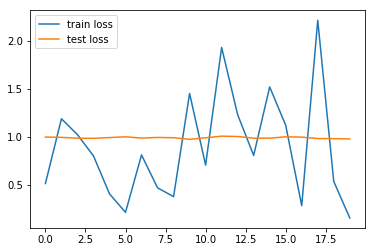

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

if not training_process:
  # Re-load trained model
  my_classifier.load_state_dict(ckpt['my_classifier'])
  optimizer.load_state_dict(ckpt['optimizer'])

  # Testing
  n = 0.
  test_loss = 0.
  test_acc = 0.
  my_classifier.eval()
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
    n += test_inputs.size(0)

  test_loss /= n
  test_acc /= n
  print('Test_loss : {:.4f}, Test accuracy : {:.4f}'.format(test_loss, test_acc))

label : deer
prediction : deer


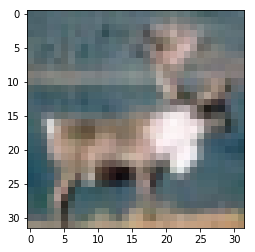

In [0]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

# <font color="blue"> Discussion and Analysis </font>

<font color="blue"> Fill here with your discussion </font>